Попробуем загрузить фотографии пиц (вид сверху) и попробуем натренировать простой сжимающий автоэнкодер. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 

import seaborn as sns

np.random.seed(42)

import cv2
import os
import sys

import load_data
import prepare_images

### Загружаем фотографии пицц

In [2]:
pizza_eng_names, pizza_imgs = prepare_images.load_photos()

Read csv...
(20, 13)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 13 columns):
city_name         20 non-null object
city_url          20 non-null object
pizza_name        20 non-null object
pizza_eng_name    20 non-null object
pizza_url         20 non-null object
pizza_contain     20 non-null object
pizza_price       20 non-null int64
kiloCalories      20 non-null object
carbohydrates     20 non-null object
proteins          20 non-null object
fats              20 non-null object
size              20 non-null int64
weight            20 non-null object
dtypes: int64(2), object(11)
memory usage: 2.1+ KB
None
['double-pepperoni', 'crazy-pizza', 'pizza-don-bekon', 'gribvetchina', 'pizza-pirog', 'pizza-margarita', 'syrnaya-pizza', 'gavayskaya-pizza', 'pizza-dodo', 'pizza-chetyre-sezona', 'ovoshi-i-griby', 'italyanskaya-pizza', 'meksikanskaya-pizza', 'morskaya-pizza', 'myasnaya-pizza', 'pizza-pepperoni', 'ranch-pizza', 'pizza-syrnyi-cyplenok', 'pi

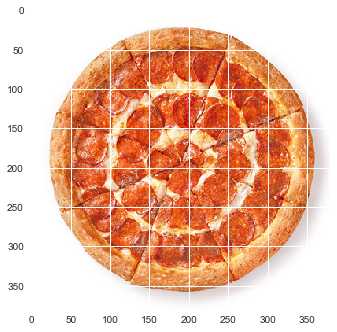

In [3]:
def plot_img(img):
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)

plot_img(pizza_imgs[0])

Замечательно, что пицца обладает осевой симметрией - для аугментации, её можно будет вращать вокруг центра, а так же отражать по вертикали.

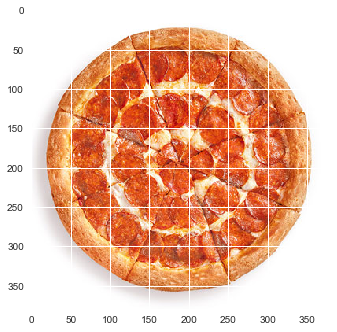

In [4]:
img_flipy = cv2.flip(pizza_imgs[0], 1)
plot_img(img_flipy)

Результат поворота вокруг центра на 15 градусов:

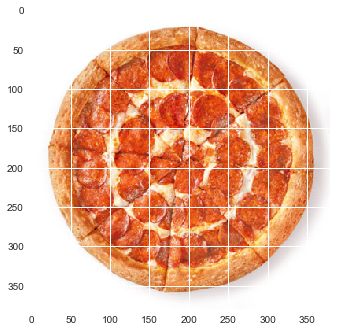

In [5]:
img_rot15 = load_data.rotate(pizza_imgs[0], 15)
plot_img(img_rot15)

Сделаем аугментацию для первой пиццы в списке (предварительно уменьшив до размеров: 56 на 56) - вращение вокруг оси на 360 градусов с шагом в 1 градус и отражением по вертикали.

In [6]:
channels, height, width = 3, 56, 56

lst0 = load_data.resize_rotate_flip(pizza_imgs[0], (height, width))
print(len(lst0))

720


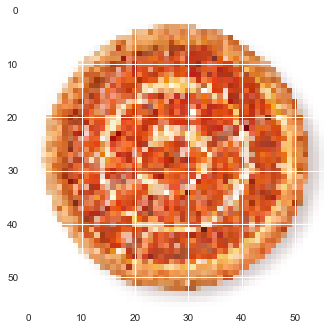

In [7]:
plot_img(lst0[0])

### Попробуем автоэнкодер
Преобразуем список с картинками к нужному виду и разобьём его на тренировочную и тестовую выборки.

In [8]:
image_list = lst0
image_list = np.array(image_list, dtype=np.float32)
image_list = image_list.transpose((0, 3, 1, 2))
image_list /= 255.0
print(image_list.shape)

(720, 3, 56, 56)


In [9]:
x_train = image_list[:600]
x_test = image_list[600:]
print(x_train.shape, x_test.shape)

(600, 3, 56, 56) (120, 3, 56, 56)


In [10]:
from keras.models import Model
from keras.layers import Input, Dense, Flatten, Reshape
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D

from keras import backend as K
#For 2D data (e.g. image), "channels_last" assumes (rows, cols, channels) while "channels_first" assumes  (channels, rows, cols).
K.set_image_data_format('channels_first')

Using Theano backend.


### Создаём автоэнкодер

In [11]:
def create_deep_conv_ae(channels, height, width):
	input_img = Input(shape=(channels, height, width))
	
	x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
	x = MaxPooling2D(pool_size=(2, 2), padding='same')(x)
	x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
	encoded = MaxPooling2D(pool_size=(2, 2), padding='same')(x)
	
	# at this point the representation is (8, 14, 14)
	
	input_encoded = Input(shape=(8, 14, 14))
	x = Conv2D(8, (3, 3), activation='relu', padding='same')(input_encoded)
	x = UpSampling2D((2, 2))(x)
	x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
	x = UpSampling2D((2, 2))(x)
	decoded = Conv2D(channels, (3, 3), activation='sigmoid', padding='same')(x)
	
	# Models
	encoder = Model(input_img, encoded, name="encoder")
	decoder = Model(input_encoded, decoded, name="decoder")
	autoencoder = Model(input_img, decoder(encoder(input_img)), name="autoencoder")
	return encoder, decoder, autoencoder

c_encoder, c_decoder, c_autoencoder = create_deep_conv_ae(channels, height, width)
c_autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

c_encoder.summary()
c_decoder.summary()
c_autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3, 56, 56)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 56, 56)        448       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 28, 28)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 28, 28)         1160      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 14, 14)         0         
Total params: 1,608
Trainable params: 1,608
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 

In [12]:
c_autoencoder.fit(x_train, x_train,
                epochs=20,
                batch_size=16,
                shuffle=True,
                verbose=2,
                validation_data=(x_test, x_test))

Train on 600 samples, validate on 120 samples
Epoch 1/20
10s - loss: 0.5840 - val_loss: 0.5305
Epoch 2/20
10s - loss: 0.4571 - val_loss: 0.4162
Epoch 3/20
9s - loss: 0.4032 - val_loss: 0.3956
Epoch 4/20
8s - loss: 0.3884 - val_loss: 0.3855
Epoch 5/20
10s - loss: 0.3829 - val_loss: 0.3829
Epoch 6/20
11s - loss: 0.3808 - val_loss: 0.3815
Epoch 7/20
9s - loss: 0.3795 - val_loss: 0.3804
Epoch 8/20
8s - loss: 0.3785 - val_loss: 0.3797
Epoch 9/20
10s - loss: 0.3778 - val_loss: 0.3787
Epoch 10/20
10s - loss: 0.3771 - val_loss: 0.3781
Epoch 11/20
9s - loss: 0.3764 - val_loss: 0.3779
Epoch 12/20
8s - loss: 0.3760 - val_loss: 0.3773
Epoch 13/20
9s - loss: 0.3756 - val_loss: 0.3768
Epoch 14/20
10s - loss: 0.3751 - val_loss: 0.3766
Epoch 15/20
10s - loss: 0.3748 - val_loss: 0.3768
Epoch 16/20
9s - loss: 0.3745 - val_loss: 0.3762
Epoch 17/20
10s - loss: 0.3741 - val_loss: 0.3755
Epoch 18/20
9s - loss: 0.3738 - val_loss: 0.3754
Epoch 19/20
11s - loss: 0.3735 - val_loss: 0.3752
Epoch 20/20
8s - loss:

In [13]:
#c_autoencoder.save_weights('c_autoencoder_weights.h5')
#c_autoencoder.load_weights('c_autoencoder_weights.h5')

### Посмотрим на результаты работы автоэнкодера

In [14]:
n = 5
imgs = x_test[:n]
encoded_imgs = c_encoder.predict(imgs, batch_size=n)
decoded_imgs = c_decoder.predict(encoded_imgs, batch_size=n)

def get_image_from_net_data(data):
	res = data.transpose((1, 2, 0))
	res *= 255.0
	res = np.array(res, dtype=np.uint8)
	return res

#image0 = get_image_from_net_data(decoded_imgs[0])
#plot_img(image0)

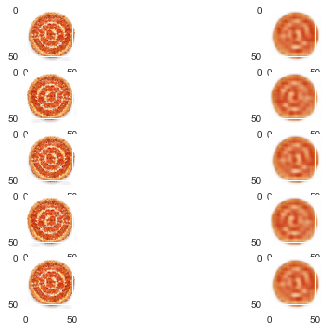

In [15]:
fig = plt.figure()
j = 0
for i in range(0, len(imgs)):
    j += 1
    fig.add_subplot(n,2,j)
    plot_img( get_image_from_net_data(imgs[i]) )
    j += 1
    fig.add_subplot(n,2,j)
    plot_img( get_image_from_net_data(decoded_imgs[i]) )